# Croissance économique et Santé
--- 
##### Par Thibaut LAUNAY, Jeanne LEMASSON et Christophe REY

# Introduction
---
Ce projet s’inscrit dans le prolongement d’un débat ancien et toujours très actif en macroéconomie et en économie du développement, concernant les liens entre la croissance économique et l’état de santé des populations. La croissance du PIB est souvent présentée comme un levier essentiel d’amélioration du bien-être, notamment par l’augmentation des revenus, l’élargissement de l’assiette fiscale et le financement accru des systèmes de santé. De nombreux travaux empiriques mettent ainsi en évidence une corrélation positive entre le niveau de revenu par habitant et divers indicateurs de santé, tels que l’espérance de vie ou la mortalité infantile.

Cependant, cette relation est loin d’être univoque. D’une part, les limites du PIB comme indicateur synthétique du bien-être sont désormais largement reconnues, et une croissance soutenue ne garantit pas nécessairement une amélioration de la santé si ses fruits sont inégalement répartis ou s’accompagnent de dégradations environnementales. D’autre part, la causalité entre croissance et santé est potentiellement bidirectionnelle : une population en meilleure santé est aussi plus productive, ce qui peut favoriser la croissance économique. Cette endogénéité complique l’identification empirique de l’effet propre de la croissance sur la santé.

On peut ainsi envisager une relation complexe, voire non linéaire, entre croissance économique et santé. Dans les pays à faible niveau de revenu, une accélération de la croissance peut permettre des investissements cruciaux dans les infrastructures sanitaires, l’accès à l’eau potable ou la nutrition, entraînant des gains rapides en matière de santé publique. En revanche, au-delà d’un certain seuil de développement, les gains marginaux de la croissance sur la santé pourraient s’atténuer, tandis que certains effets négatifs comme le stress, la pollution, ou le changement des modes de vie, pourraient limiter, voire inverser ces bénéfices.

Par ailleurs, si les effets de la croissance économique sur la santé physique ont été relativement bien documentés, la question de la santé mentale demeure plus controversée et moins systématiquement intégrée aux analyses macroéconomiques. Or, les troubles mentaux constituent aujourd’hui un enjeu majeur de santé publique à l’échelle mondiale, tant en termes de prévalence que de coûts économiques et sociaux. Stress lié au travail, urbanisation rapide, intensification des rythmes de vie, isolement social ou encore pression à la performance sont autant de facteurs susceptibles de s’accentuer avec le développement économique et de peser négativement sur le bien-être psychologique des individus. Ainsi, une hausse du PIB par habitant pourrait coexister avec une stagnation, voire une dégradation, de l’état de santé mentale des populations.

Ces mécanismes ont été étudiés de manière relativement fragmentée dans la littérature économique, avec des résultats parfois contradictoires selon les indicateurs retenus, les périodes considérées et les méthodes économétriques employées. L’objectif de ce projet est donc d’examiner empiriquement la relation entre croissance économique et santé à partir de données internationales, en distinguant explicitement les dimensions de santé physique et de santé mentale, afin d’identifier l’existence éventuelle de non-linéarités et de mieux comprendre les conditions sous lesquelles la croissance se traduit, ou non, par une amélioration durable et globale de l’état de santé des populations.

NB : par souci de lisibilité, certaines fonctions ont été rassemblées dans des scripts et n’apparaissent pas directement dans ce notebook.

### Problématique

Le développement économique d’un pays s’accompagne-t-il nécessairement d’une amélioration de l’état de santé de sa population, ou ses effets diffèrent-ils selon les dimensions de la santé, notamment entre santé physique et santé mentale ?

## Sommaire

### I. Installation  
- Préparation des données  

---

### II. Données de santé   
- Indicateurs de santé  
- Valeurs manquantes  
- Description élémentaire  
- Cartographie  

---

### III. Données IHME
- Indicateurs de santé mentale 
- Valeurs manquantes  
- Description élémentaire  
- Cartographie  

---

### IV. Croissance économique   
- PIB par habitant 
- Valeurs manquantes  
- Description élémentaire  
- Cartographie   

---

### V. Analyse  
- Fusion des bases de données  
- Impact du développement économique sur les indicateurs de santé générale et infrastructures
- Impact du développement économique sur les indicateurs de santé mentale
- Question de la réciprocité du lien économie-santé : les indicateurs sanitaires stimulent-ils la croissance économique ?

---

### VI. Conclusion et perspectives  


# Installation
---
### Préparation des données

In [102]:
%pip install pycountry

# Module
import pandas as pd
import requests
import pycountry
import io
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Fonctions
from OMS_code_pays import get_headers
from OMS_code_pays import get_facts
from OMS_code_pays import get_iso3
from OMS_code_pays import build_wide_table
from OMS_code_pays import get_data_health_with_iso
import graphiques as gp
import importlib
import pandas as pd
from reg_multiple_sante import analyse_sante_vers_pib, graphique_valeurs_predites_vs_reelles, graphique_coefficients
from PIB_hab import get_gdp_per_capita_wide
from PIB_hab import get_gdp_per_capita
from desc_indicateur import desc_missing_pib
from desc_indicateur import desc_missing_health
from analyse_pib_habitant import plot_missing_gdp
from analyse_pib_habitant import world_map_gdp
from analyse_pib_habitant import decile_gdp
from analyse_OMS import world_map
from analyse_OMS import description_indicateurs
from Pays_ONU import onu
from Pays_ONU import pas_onu

Note: you may need to restart the kernel to use updated packages.


# Données OMS
---
### Indicateurs de santé
Nous utilisons des données issues de l’Organisation mondiale de la santé (OMS) afin d’analyser empiriquement le lien entre le niveau de PIB par habitant et l’état de santé des populations. Ces données offrent une couverture internationale étendue et permettent d’appréhender plusieurs dimensions essentielles de la santé, au-delà des seuls indicateurs de mortalité. Afin de ne pas multiplier les variables et de conserver une analyse lisible, nous avons retenu un ensemble restreint d’indicateurs particulièrement pertinents au regard de notre problématique.

Tout d’abord, pour rendre compte de l’état de santé physique général et de la longévité des populations, nous mobilisons l’espérance de vie à la naissance (**Espérance de vie totale**) ainsi que des indicateurs de mortalité néonatale pour 1000 naissances (**Taux de mortalité brute**) et de mortalité maternelle pour 100 000 naissances (**Mortalité maternelle à la naissance**), qui reflètent la qualité des soins et l’accès aux services de santé, notamment lors des phases critiques de la naissance. Par ailleurs, la santé et la nutrition infantiles sont appréhendées à travers la prévalence du retard de croissance chez les enfants de moins de cinq ans (%) (**Retard de croissance des enfants**) et du surpoids infantile (%) (**Surpoids des enfants de moins de 5 ans**), permettant d’examiner les effets différenciés de la croissance économique selon le niveau de développement.

Ensuite, afin de mesurer le degré de développement et la capacité des systèmes de santé, nous retenons la part des dépenses publiques de santé dans les dépenses totales des administrations publiques (**Dépenses publiques de santé**) ainsi que la densité de médecins pour 10 000 habitants (**Médecins pour 10 000 habitants**). Enfin, dans le but d’intégrer la dimension de santé mentale, encore peu prise en compte dans les analyses macroéconomiques, nous incluons le taux de mortalité par suicide pour 100 000 habitants (**Taux de suicides**), qui constitue un indicateur disponible et comparable à l’échelle internationale.

#### Choix des variables

Le choix de restreindre nos tables à ces variables précises repose sur la qualité de leur corrélation avec le développement économique et leur robustesse statistique :

- **Variables à fort pouvoir explicatif** ($R^2$ élevé) : Nous avons privilégié les variables ayant un fort pouvoir explicatif. Par exemple, pour l'espérance de vie, le retard de croissance ou les troubles alimentaires, le PIB explique plus de 60 % de leur variation ($R^2$ > 0.60). Ces indicateurs sont des marqueurs fiables : quand l'économie bouge, ces variables réagissent de manière prévisible et linéaire.

- **Variables de rupture** (faible $R^2$) : À l'inverse, nous avons conservé des indicateurs dont la variation n'est pas dictée par la richesse. Ce choix volontaire permet de démontrer que la croissance a ses limites, notamment sur les choix politiques et le bien-être psychologique.
    - Le taux de suicide et les troubles mentaux (IHME) échappent à la logique purement financière, soulignant que la richesse ne protège pas contre la détresse mentale.
    - Les dépenses publiques de santé et la densité de médecins pour 10 000 habitants montrent que l'offre de soins dépend davantage de la volonté politique que du niveau de PIB brut.

- **Qualité et standardisation des données** : Les indicateurs retenus (comme ceux portant sur les troubles mentaux et alimentaires de l'IHME ou les données de mortalité de l'OMS comme l'espérance de vie totale, la mortalité néonatale ou la mortalité maternelle) sont les plus standardisés au niveau international. Cela limite les biais de mesure et assure une meilleure cohérence lors de la fusion des bases de données, garantissant ainsi la validité de nos modèles de régression.

- **Sensibilité aux paliers de revenus** : Nous avons choisi des variables qui présentent des évolutions critiques lors du passage d'un groupe de revenu à l'autre, validant ainsi l'existence de "seuils de développement".
    - La mortalité maternelle à la naissance et le taux de mortalité brute (néonatale) chutent drastiquement dès la sortie de la catégorie "Low Income".
    - Le surpoids des enfants de moins de 5 ans et le Retard de croissance illustrent parfaitement le "double fardeau nutritionnel": le premier augmente tandis que le second s'effondre à mesure que les pays changent de palier de revenu.

Les données sont récupérées via l'API de l'OMS (via un code disponible dans le fichier OMS_code_pays.py).

In [103]:
dfs = get_data_health_with_iso()

df_sdg3 = dfs["SDG3"]
df_sdg_gpw = dfs["SDG_GPW"]

In [104]:
df_sdg3

,LOCATION,Pays_code_iso3,HWF_0001,SDGSUICIDE,WHOSIS_000001_BTSX,WHOSIS_000003,MDG_0000000026
0,Afghanistan,AFG,3.17,3.6,59.1,34.3,521
1,Albania,ALB,18.79,2.8,76.4,6.9,7
2,Algeria,DZA,16.6,2.2,76.0,15.3,62
3,Andorra,AND,50.68,NaN,NaN,1.3,11
4,Angola,AGO,2.44,8.1,62.1,25.6,183
...,...,...,...,...,...,...,...
193,Venezuela (Bolivarian Republic of),None,16.64,8.6,71.2,15.0,227
194,Viet Nam,VNM,11.07,7.3,73.8,10.3,48
195,Yemen,YEM,0.98,4.2,65.8,21.4,118
196,Zambia,ZMB,3.24,7.1,61.0,22.0,85


In [105]:
df_sdg_gpw

,LOCATION,Pays_code_iso3,NUTOVERWEIGHTPREV,GHED_GGHE_DGGE_SHA2011,NUTSTUNTINGPREV
0,Afghanistan,AFG,4.4,1.13,42.0
1,Albania,ALB,16.7,9.19,7.4
2,Algeria,DZA,13.3,5.36,8.9
3,Andorra,AND,NaN,15.87,NaN
4,Angola,AGO,4.7,6.7,47.7
...,...,...,...,...,...
193,Venezuela (Bolivarian Republic of),None,7.3,6.01,11.7
194,Viet Nam,VNM,10.5,10.7,19.2
195,Yemen,YEM,1.7,2.51,47.4
196,Zambia,ZMB,6.3,8.89,32.3


Ces dataframes ont été sauvegardés en format csv pour compléter les derniers codes pays n'ayant pas été créés par le module pycountry et pour renommer les colonnes nommées par des codes non-explicites. Les fichiers modifiés sont : WHO_SDG_GPW_standardisé_avec_code_pays_complet.csv et WHO_SDG3_standardisé_avec_code_pays_complet.csv du dossier Données OMS.

In [106]:
df_gpw = pd.read_csv('Données_OMS/WHO_SDG_GPW_standardisé_avec_code_pays_complet.csv')
df_gpw

,LOCATION,Pays_code_iso3,Surpoids enfants <5 ans,Dépenses publiques santé,Retard croissance enfants
0,Afghanistan,AFG,4.4,1.13,42.0
1,Albania,ALB,16.7,9.19,7.4
2,Algeria,DZA,13.3,5.36,8.9
3,Andorra,AND,NaN,15.87,NaN
4,Angola,AGO,4.7,6.70,47.7
...,...,...,...,...,...
192,Venezuela,VEN,7.3,6.01,11.7
193,Viet Nam,VNM,10.5,10.70,19.2
194,Yemen,YEM,1.7,2.51,47.4
195,Zambia,ZMB,6.3,8.89,32.3


In [10]:
df_sdg3 = pd.read_csv('Données_OMS/WHO_SDG3_standardisé_avec_code_pays_complet.csv')
df_sdg3

NameError: name 'pd' is not defined

### Valeurs manquantes
---

In [6]:
desc_missing_health(df_sdg3, 'Espérance de vie totale', 'LOCATION')
desc_missing_health(df_sdg3, 'Taux mortalité brute', 'LOCATION')
desc_missing_health(df_sdg3, 'Médecins pour 10k habitants', 'LOCATION')
desc_missing_health(df_sdg3, 'Taux de suicides', 'LOCATION')
desc_missing_health(df_sdg3, 'Mortalité Maternelle à la naissance', 'LOCATION')
desc_missing_health(df_gpw, 'Dépenses publiques santé', 'LOCATION')

NameError: name 'desc_missing_health' is not defined

In [109]:
desc_missing_health(df_gpw, 'Surpoids enfants <5 ans', 'LOCATION')
desc_missing_health(df_gpw, 'Retard croissance enfants', 'LOCATION')

The dataframe includes 197 countries and 36 missing values.
The percentage of missing values for Surpoids enfants <5 ans in the dataset is 18.27%.
The dataframe includes 197 countries and 37 missing values.
The percentage of missing values for Retard croissance enfants in the dataset is 18.78%.


Les valeurs manquantes sont globalement peu nombreuses pour l’ensemble des indicateurs, à l’exception de **Surpoids des enfants de moins de 5 ans** et **Retard de croissance des enfants**. Pour ces deux indicateurs, les données manquantes concernent principalement des pays développés tels que les États-Unis, la France et plusieurs pays européens.

L’imputation par la moyenne ou la médiane n’est pas appropriée, car ces indicateurs varient fortement selon le niveau de développement des pays. Une telle imputation introduirait un biais important en attribuant à des pays à hauts revenus des valeurs représentatives de contextes très différents. De plus, la distribution de ces indicateurs n’est pas homogène et dépend de facteurs structurels, ce qui rend une imputation statistique peu fiable.

Nous n'avons pas réussi à trouver des données complémentaires.

En l’absence de solution fiable, les valeurs manquantes sont conservées et leur présence sera prise en compte avec prudence lors des analyses et de l’interprétation des résultats.

### Description élémentaire
---
Pour décrire certains de ces indicateurs de façon élémentaire, nous présenterons leur moyenne, leur médiane, leur minimum / maximum, leur écart-type et un boxplot pour analyser leur distribution.


In [9]:
description_indicateurs(df_sdg3, ['Espérance de vie totale','Médecins pour 10k habitants','Dépenses publiques santé'])

NameError: name 'description_indicateurs' is not defined

Bien que l’espérance de vie soit globalement stable autour de 72 ans, l’écart important entre la moyenne et la médiane des médecins (3,82 contre 2,41) montre qu’une minorité de pays concentre l’essentiel des ressources médicales et des investissements publics.

In [8]:
description_indicateurs(df_sdg3, ['Retard croissance enfants','Mortalité Maternelle à la naissance','Surpoids enfants <5 ans'])

NameError: name 'description_indicateurs' is not defined

L'écart-type colossal de la mortalité maternelle (165,52) et le maximum de retard de croissance (55,30 %) témoignent de conditions sanitaires critiques dans certaines régions, alors que la présence simultanée de surpoids infantile (jusqu'à 26,40 %) souligne l'émergence d'un "double fardeau nutritionnel" où coexistent carences graves et surnutrition au niveau mondial.

Statistiques descriptives :

                           Moyenne  Médiane  Minimum  Maximum  Écart-type
Surpoids enfants <5 ans       6.76     5.50     0.60    26.40        4.16
Dépenses publiques santé     10.82     9.82     1.13    29.51        5.49
Retard croissance enfants    16.29    12.00     1.00    55.30       12.82


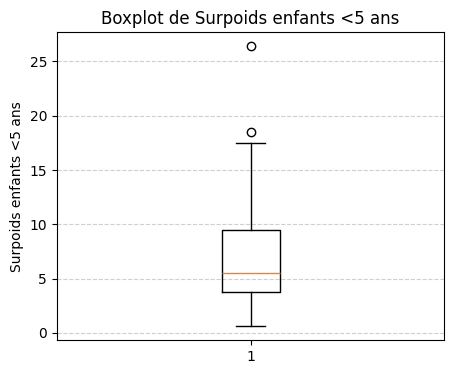

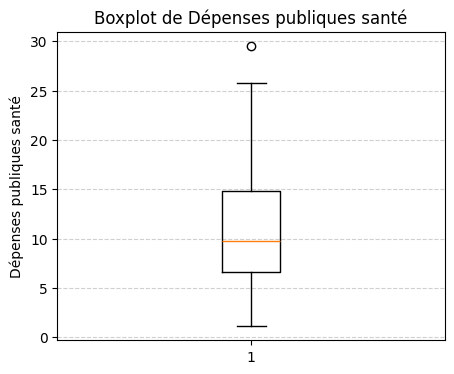

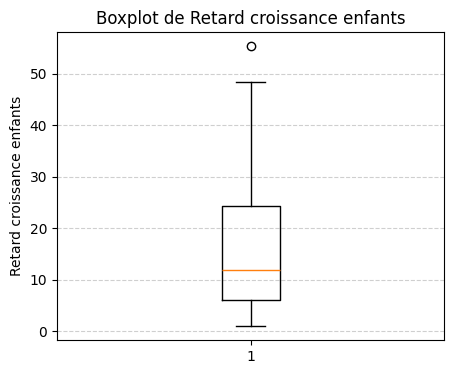

In [ ]:
description_indicateurs(df_gpw, ['Taux mortalité brute','Taux de suicides'])

La disparité du taux de mortalité brute reflète des réalités démographiques opposées entre pays jeunes et pays vieillissants, tandis que le taux de suicide, avec une moyenne de 8,59 et un écart-type plus modéré de 6,00, suggère que les enjeux de santé mentale sont une problématique transversale qui touche l'ensemble des nations, indépendamment de leur niveau de richesse global.

### Cartographie
---

In [112]:
world_map(df_gpw, y_col="Dépenses publiques santé", data_name="Dépenses publiques générales de santé en pourcentage des dépenses publiques générales (%)")
world_map(df_gpw, y_col = "Retard croissance enfants", data_name="Prévalence du retard de croissance chez les enfants de moins de 5 ans (%)")
world_map(df_sdg3, y_col='Espérance de vie totale', data_name='Espérance de vie à la naissance (années)')
world_map(df_sdg3, y_col='Taux mortalité brute', data_name='Taux de mortalité néonatale (pour 1000 naissances vivantes)')
world_map(df_sdg3, y_col='Médecins pour 10k habitants', data_name='Densité de médecins (pour 10 000 habitants)')
world_map(df_sdg3, y_col='Taux de suicides', data_name='Taux de mortalité par suicide (pour 100 000 habitants)')

La comparaison des cartes de l’espérance de vie et de la mortalité néonatale révèle une fracture géographique nette : l'Afrique subsaharienne et une partie de l'Asie centrale concentrent les taux de mortalité les plus élevés (en rouge), ce qui pèse mécaniquement sur une espérance de vie stagnante sous la barre des 60 ans, tandis que les pays du Nord affichent une homogénéité dans la longévité.

La carte des dépenses de santé montre que l'effort budgétaire n'est pas réservé aux pays riches. Si l'Amérique du Nord et l'Océanie investissent massivement, certains pays d'Afrique affichent des pourcentages comparables à certains pays européens, suggérant que la difficulté réside moins dans la part du budget allouée que dans le montant absolu disponible et l'efficacité des infrastructures. La carte de la densité médicale souligne un désert sanitaire criant en Afrique et dans une partie de l'Asie du Sud-Est (zones sombres), où l'on compte parfois moins d'un médecin pour 10 000 habitants.

Le retard de croissance infantile dessine une carte de la précarité nutritionnelle très localisée : alors que les Amériques et l'Europe ont quasiment éradiqué ce fléau (bleu foncé), des foyers critiques persistent en Afrique de l'Est et en Asie du Sud, témoignant d'une corrélation étroite entre faible PIB par habitant et insécurité alimentaire chronique. 

La carte du suicide brouille les lignes habituelles du développement économique : les taux les plus élevés ne se trouvent pas nécessairement dans les pays les plus pauvres, mais semblent suivre des logiques culturelles et sociales spécifiques, notamment en Europe de l'Est et en Afrique australe, confirmant que la richesse monétaire ne protège pas systématiquement contre la détresse psychologique. 

# Données IHME
---
### Indicateurs de santé mentale
Nous avons ensuite souhaité élargir l’analyse à des dimensions de la santé qui ne coïncident pas toujours avec les indicateurs de santé physique générale, en particulier la santé mentale et la santé alimentaire. Ces dimensions sont essentielles pour appréhender le bien-être global des populations et peuvent évoluer différemment selon le niveau de richesse d’un pays.
Pour cela, nous avons récupéré les données de l'IHME (INSTITUTE FOR HEALTH METRICS AND EVALUATION) afin d'avoir de nombreuses données relatives à la santé mentale et alimentaire et compléter le jeu de données provenant du site de l'OMS. Ainsi, nous avons sélectionné quatre variables clés : le taux de suicide et la prévalence des troubles mentaux pour la santé mentale, ainsi que les troubles du comportement alimentaire et le surpoids chez les enfants de moins de cinq ans pour la santé alimentaire. Les indicateurs de santé mentale révèlent des vulnérabilités souvent moins visibles, liées aux conditions socio-économiques et aux modes de vie. Les variables alimentaires, quant à elles, illustrent les transitions nutritionnelles associées au développement économique, où malnutrition et excès peuvent coexister. 
Ces indicateurs complètent ainsi l’analyse en apportant une vision plus nuancée et globale de la relation entre richesse économique et santé.

En raison des restrictions d'accès (blocage du scraping) sur le site 'Our World in Data', nous avons procédé à un import manuel des données sous format CSV. Cependant les données n'étaient pas organisées correctement pour pouvoir être fusionnées directement avec les données de l'OMS. En effet, les variables d'intérêt n'étaient pas associées à une colonne et chaque pays avait plusieurs lignes associées qui reprenaient chacune la valeur d'une des variables d'intérêt. Nous avons donc restructuré le jeu de données en associant une colonne à chaque variable d’intérêt, de sorte que l’ensemble des informations relatives à un pays soit regroupé sur une seule ligne. Cette transformation permet d’obtenir une structure identique à celle des données de l’OMS, facilitant ainsi leur fusion et la possibilité de travailler sur les deux jeux de données à la fois.

Les données de l'IHME ont été restructurées avec le code suivant


In [5]:
import pandas as pd
import sys
import subprocess


# Le fichier source 
INPUT_FILE = "Données_IHME/IHME_Mental_Health_2021.csv"

# Le fichier de sortie (Tableau restructuré)
OUTPUT_FILE = "Données_IHME/IHME_Mental_Health_WIDE.csv"


def restructure_data(input_path):
    print(f"1. Chargement du fichier : {input_path}")
    df = pd.read_csv(input_path)
    
    # Vérification des colonnes
    print(f"   Colonnes trouvées : {list(df.columns)}")
    
    # On ne garde que les 3 colonnes essentielles pour le pivot
    # 'val' contient le nombre de DALYs, 'cause' la maladie, 'location' le pays
    df_reduced = df[['location', 'cause', 'val']]
    

    # - index='location_' : Chaque pays devient une ligne unique
    # - columns='cause' : Chaque maladie devient une colonne
    # - values='val' : On remplit les cases avec le nombre de DALYs
    df_wide = df_reduced.pivot(index='location', columns='cause', values='val')
    
    # Après un pivot, l'index est complexe, on le remet à plat pour avoir une colonne 'Pays' normale
    df_wide = df_wide.reset_index()
    
    # 3. Nettoyage des noms de colonnes)
    df_wide.columns = [
        str(col).replace(' ', '_')      # Remplace espace par _
                .replace('-', '_')      # Remplace tiret par _
                .replace('/', '_')      # Remplace slash par _
                .replace('(', '')       # Enlève parenthèse ouvrante
                .replace(')', '')       # Enlève parenthèse fermante
                .replace("'", "")       # Enlève apostrophe
        for col in df_wide.columns
    ]
    
    # On renomme la colonne pays pour que le tableau de données soit clair
    df_wide = df_wide.rename(columns={'location_name': 'Country'})
    
    return df_wide


if __name__ == "__main__":
    try:
        # Exécution de la restructuration
        df_clean = restructure_data(INPUT_FILE)
        
        # Sauvegarde
        df_clean.to_csv(OUTPUT_FILE, index=False)
        
        print("\n" + "="*40)
        print("SUCCÈS ! TABLEAU RESTRUCTURÉ")
        print("="*40)
        print(f"Fichier sauvegardé ici : {OUTPUT_FILE}")
        print(f"Nombre de lignes (Pays) : {len(df_clean)}")
        print(f"Nombre de colonnes (Maladies) : {len(df_clean.columns)}")
        print("-" * 40)
        print("Aperçu des nouvelles colonnes :")
        print(df_clean.columns.tolist())
        
    except FileNotFoundError:
        print(f"ERREUR : Impossible de trouver le fichier {INPUT_FILE}")
    except KeyError as e:
        print(f"ERREUR : Colonne manquante {e}.")


1. Chargement du fichier : Données_IHME/IHME_Mental_Health_2021.csv
   Colonnes trouvées : ['measure', 'location', 'sex', 'age', 'cause', 'metric', 'year', 'val', 'upper', 'lower']

SUCCÈS ! TABLEAU RESTRUCTURÉ
Fichier sauvegardé ici : Données_IHME/IHME_Mental_Health_WIDE.csv
Nombre de lignes (Pays) : 204
Nombre de colonnes (Maladies) : 12
----------------------------------------
Aperçu des nouvelles colonnes :
['location', 'Anxiety_disorders', 'Attention_deficit_hyperactivity_disorder', 'Autism_spectrum_disorders', 'Bipolar_disorder', 'Conduct_disorder', 'Depressive_disorders', 'Eating_disorders', 'Idiopathic_developmental_intellectual_disability', 'Mental_disorders', 'Other_mental_disorders', 'Schizophrenia']


In [113]:
df_ihme = pd.read_csv('Données_IHME/IHME_Mental_Health_WIDE.csv')
df_ihme = df_ihme[['LOCATION','Eating_disorders', 'Mental_disorders']]
df_ihme["Pays_code_iso3"] = df_ihme["LOCATION"].apply(get_iso3)
df_ihme

,LOCATION,Eating_disorders,Mental_disorders,Pays_code_iso3
0,Afghanistan,29.884592,2244.603665,AFG
1,Albania,41.508016,1747.731707,ALB
2,Algeria,55.204026,2136.247787,DZA
3,American Samoa,37.548428,1747.001294,ASM
4,Andorra,108.610874,2595.957111,AND
...,...,...,...,...
199,Venezuela,59.743006,2180.483571,VEN
200,Viet Nam,31.178021,1282.632724,VNM
201,Yemen,31.169489,2166.663536,YEM
202,Zambia,28.744829,1995.475803,ZMB


Les indicateurs sont exprimés en DALYs.
Les **DALYs** ou **années de vie ajustées sur l’incapacité** sont une mesure qui permet de quantifier le **fardeau global d'une maladie ou d'un trouble** sur une population. 

Cette métrique combine deux composantes :

1. **Années de vie perdues (YLL, Years of Life Lost)** : elles représentent le nombre d'années perdues à cause d’un décès prématuré attribuable à la maladie.
2. **Années vécues avec incapacité (YLD, Years Lived with Disability)** : elles correspondent au nombre d'années vécues avec la maladie, pondéré selon la gravité de l’incapacité causée.

### Valeurs manquantes
---

In [114]:
desc_missing_health(df_ihme, 'Eating_disorders', 'LOCATION')
desc_missing_health(df_ihme, 'Mental_disorders', 'LOCATION')

The dataframe includes 204 countries and 0 missing values.
The percentage of missing values for Eating_disorders in the dataset is 0.00%.
The dataframe includes 204 countries and 0 missing values.
The percentage of missing values for Mental_disorders in the dataset is 0.00%.


### Description élémentaire
---
De même que pour les données OMS, pour décrire les indicateurs de façon élémentaire, nous présenterons leur moyenne, leur médiane, leur minimum / maximum, leur écart-type et un boxplot pour analyser leur distribution.

Statistiques descriptives :

                  Moyenne  Médiane  Minimum  Maximum  Écart-type
Eating_disorders    57.70    46.52    16.25   214.80       33.23
Mental_disorders  2076.63  2069.39  1282.63  3271.43      370.66


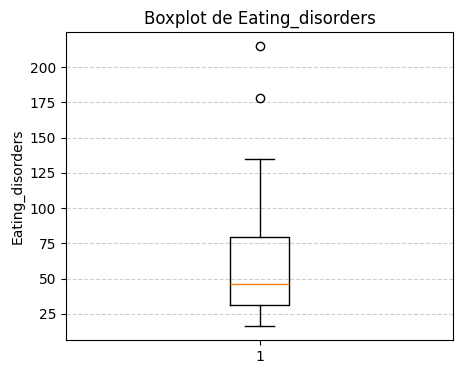

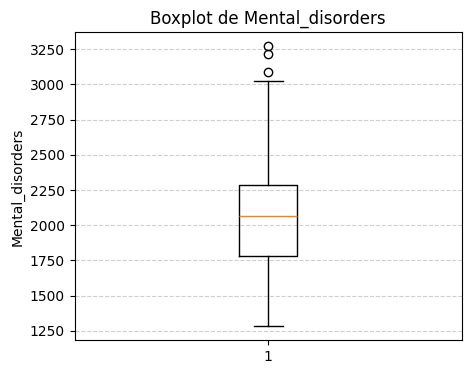

In [115]:
description_indicateurs(df_ihme, ['Eating_disorders', 'Mental_disorders'])

Texte d'analyse des descriptions

### Cartographie
---

In [116]:
world_map(df_ihme, y_col = 'Eating_disorders', data_name='Fardeau des troubles alimentaires : DALYs pour 100 000 habitants')
world_map(df_ihme, y_col = 'Mental_disorders', data_name='Fardeau des troubles mentaux : DALYs pour 100 000 habitants')

# Croissance économique
---
### PIB par habitant
Nous utilisons le PIB par habitant pour rendre compte du niveau de richesse des pays car cet indicateur indique le niveau de revenu individuel moyen de la population et n'est donc pas biaisé par la taille du pays comme c'est le cas avec le PIB. Cela le rend plus pertinent pour classer les pays en termes de revenus.

Les données sont récupérées via l'API de la WorldBank (et sont sauvegardées dans le fichier Données_PIB_habitant_2015_2024.py)

In [117]:

df = get_gdp_per_capita_wide()
df

,Country Name,Country Code,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,AFG,565.569730,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,413.757895,NaN
1,Africa Eastern and Southern,AFE,1498.875240,1334.470500,1528.104224,1552.073722,1507.085600,1351.591669,1562.416175,1679.327622,1571.449189,1615.396356
2,Africa Western and Central,AFW,1860.727686,1630.039439,1574.230564,1720.140092,2216.385055,2030.861659,2112.794076,2138.473153,1841.855064,1411.337029
3,Albania,ALB,4199.539129,4457.634122,5006.360130,5897.654526,6069.439031,6027.913507,7242.455131,7756.961887,9730.869219,11377.775743
4,Algeria,DZA,4685.059027,4424.985290,4554.667540,4577.210292,4468.453419,3743.541952,4160.559267,4960.303343,5370.477235,5752.990767
...,...,...,...,...,...,...,...,...,...,...,...,...
261,West Bank and Gaza,PSE,3272.154324,3527.613824,3620.360487,3562.330943,3656.858271,3233.568638,3678.635657,3799.955270,3455.028529,2592.305912
262,World,WLD,10161.944577,10204.928776,10747.764307,11309.383077,11376.081813,10937.684621,12390.668672,12798.165847,13236.716396,13631.204310
263,"Yemen, Rep.",YEM,1362.173812,975.359417,811.165970,633.887202,NaN,NaN,NaN,NaN,NaN,NaN
264,Zambia,ZMB,1295.877887,1239.085279,1483.465773,1463.899979,1258.986198,951.644317,1127.160779,1447.123101,1330.727806,1187.109434


### Valeurs manquantes
---

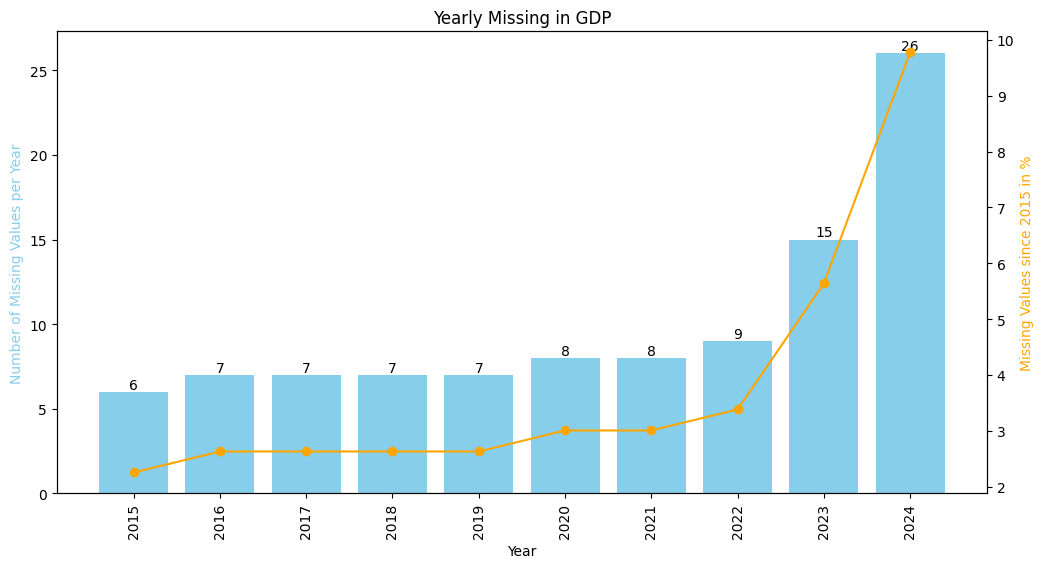

In [118]:
df = get_gdp_per_capita()
plot_missing_gdp(df)

L’analyse des données manquantes du PIB par habitant montre que les années 2015 à 2022 présentent un taux de valeurs manquantes relativement faible, compris entre 2 et 3 %. En revanche, on observe une augmentation notable pour 2023 et 2024, avec respectivement 15 et 26 valeurs manquantes, soit près de 6 % et 10 % des observations. Cette progression s’explique principalement par le fait que les données économiques les plus récentes sont souvent publiées avec un certain retard ou ne sont pas encore disponibles pour certains pays, ce qui réduit la couverture pour les années les plus proches du présent. C'est la même chose pour nos indicateurs de santé qui sont rarement datés de 2024 donc on peut dire que le nombre de données manquantes est négligeable.

### Cartographie
---

In [119]:
world_map_gdp(df)

L'évolution cartographiée du PIB par habitant entre 2015 et 2024 révèle une grande inertie structurelle des écarts de richesse, où les pôles de haute prospérité (Amérique du Nord, Europe de l'Ouest, Océanie) et les régions à faible revenu (Afrique subsaharienne, Asie du Sud) conservent une position géographique quasi inchangée sur la décennie, même si des variations régionales, notamment l'impact du COVID-19 en 2020 et la reprise post-crise, sont visibles. 

La période 2021-2024 témoigne d'une reprise en V, bien que polarisée : les régions déjà riches retrouvent rapidement leurs niveaux de revenu élevés, tandis que les zones déjà à faible revenu n'affichent que des variations marginales, soulignant que la crise a surtout accentué les inégalités préexistantes sans modifier la structure fondamentale de la richesse mondiale. 

### Description élémentaire
---
Pour saisir la dynamique du développement économique et l'évolution des inégalités, nous visualisons l'évolution de la moyenne du PIB par habitant et sa répartition par quartiles.

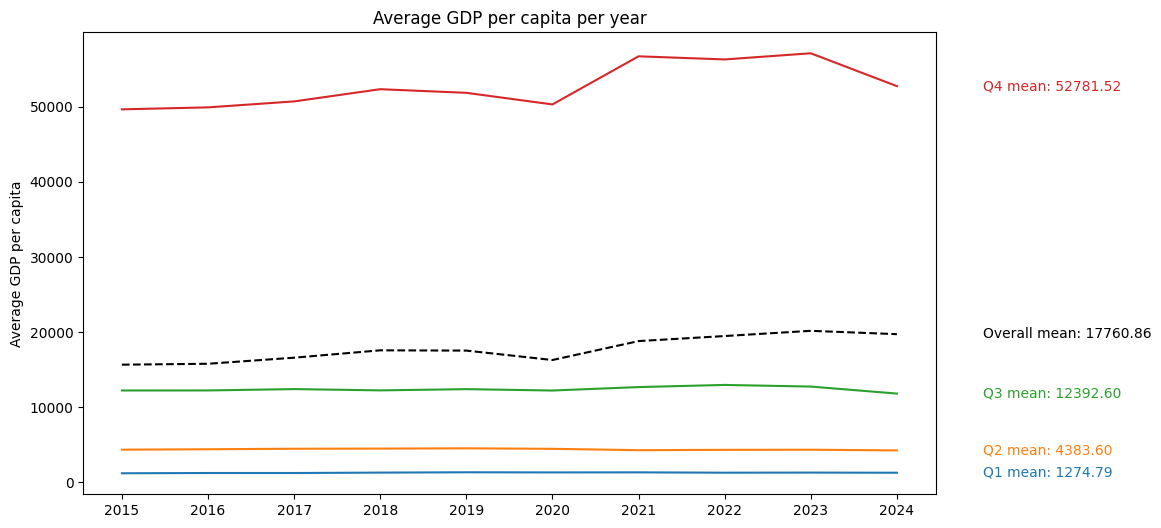

In [120]:
decile_gdp(df, 4)

Le graphique révèle une profonde inégalité de revenu à l'échelle mondiale, où le quartile le plus riche (Q4, en rouge) représente à lui seul une moyenne de revenu plus de quarante fois supérieure à celle du quartile le plus pauvre (Q1, en bleu). De plus, l'observation de la décennie 2015-2024 met en évidence une résilience polarisée face à la crise de 2020 : tandis que les trois premiers quartiles (Q1, Q2, Q3) affichent une évolution relativement stable, seul le quartile supérieur (Q4) subit et récupère de manière très marquée la chute en V du PIB par habitant, accentuant potentiellement l'écart avec le reste du monde.

# Analyse

---

### Fusion des bases de données

---

La table construite ici est enregistrée au format csv au nom de Table_fusion.csv.
Par la suite on y rajoute un groupement des pays par niveau de richesse dans le csv au nom de Table_fusion_income_groupe.csv.

In [121]:
# Chargement des trois fichiers
df_gpw = pd.read_csv('Données_OMS/WHO_SDG_GPW_standardisé_avec_code_pays_complet.csv')
df_sdg3 = pd.read_csv('Données_OMS/WHO_SDG3_standardisé_avec_code_pays_complet.csv')
df_PIB = get_gdp_per_capita_wide()
df_ihme = pd.read_csv('Données_IHME/IHME_Mental_Health_WIDE.csv')
df_ihme = df_ihme[['LOCATION','Eating_disorders', 'Mental_disorders']] # Sélection des deux indicateurs nous intéressant

# MERGE GPW + SDG3

keys_oms = ['LOCATION','Pays_code_iso3']

missing_keys = [k for k in keys_oms if k not in df_gpw.columns or k not in df_sdg3.columns]
if missing_keys:
    print(f"Colonnes clés absentes : {missing_keys}")
else:
    df_fusion_oms = pd.merge(df_gpw,df_sdg3,on=keys_oms,how='inner')

# MERGE avec IHME

key_health = 'LOCATION'

df_fusion_health = pd.merge(df_fusion_oms,df_ihme,on=key_health,how='inner')

# MERGE avec le PIB

key_pib_left = 'Pays_code_iso3'
key_pib_right = 'Country Code'

df_final = pd.merge(df_fusion_health,df_PIB,left_on=key_pib_left,right_on=key_pib_right,how='inner')
df_final = df_final.drop(['Country Name','Country Code'], axis=1)

# MERGE avec le niveau de richesse pour graphiques barres

df_income_group = pd.read_csv('Données Income group/Données_niveau_richesse.csv')

key_left = 'Pays_code_iso3'
key_right = 'Country Code'

df_final_income_group = pd.merge(df_final,df_income_group,left_on=key_left,right_on=key_right,how='inner')
df_final_income_group = df_final_income_group.drop(['Country Name','Country Code'], axis=1)

In [122]:
df_final

,LOCATION,Pays_code_iso3,Surpoids enfants <5 ans,Dépenses publiques santé,Retard croissance enfants,Espérance de vie totale,Taux mortalité brute,Médecins pour 10k habitants,Taux de suicides,Mortalité Maternelle à la naissance,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,AFG,4.4,1.13,42.0,59.1,34.3,0.06,3.6,521.0,...,565.569730,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,413.757895,NaN
1,Albania,ALB,16.7,9.19,7.4,76.4,6.9,10.27,2.8,7.0,...,4199.539129,4457.634122,5006.360130,5897.654526,6069.439031,6027.913507,7242.455131,7756.961887,9730.869219,11377.775743
2,Algeria,DZA,13.3,5.36,8.9,76.0,15.3,3.57,2.2,62.0,...,4685.059027,4424.985290,4554.667540,4577.210292,4468.453419,3743.541952,4160.559267,4960.303343,5370.477235,5752.990767
3,Andorra,AND,NaN,15.87,NaN,NaN,1.3,12.11,NaN,11.0,...,38654.952879,40129.838581,40672.971742,42819.757746,41257.816459,37361.107008,42425.706645,42414.047986,46812.426101,49303.649167
4,Angola,AGO,4.7,6.70,47.7,62.1,25.6,0.07,8.1,183.0,...,3641.728939,2051.814621,2790.718869,2860.093648,2493.678844,1759.356199,2303.908127,3682.113151,2916.136633,2665.874448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Venezuela,VEN,7.3,6.01,11.7,71.2,15.0,1.35,8.6,227.0,...,4103.138499,3670.157378,3791.331607,3422.654670,2523.112752,1506.043621,2004.933979,3155.042071,3617.435946,4217.591026
189,Viet Nam,VNM,10.5,10.70,19.2,73.8,10.3,NaN,7.3,48.0,...,2577.568853,2735.060438,2956.109921,3222.310031,3440.900254,3534.039535,3704.193559,4147.697772,4323.350320,4717.290287
190,Yemen,YEM,1.7,2.51,47.4,65.8,21.4,0.19,4.2,118.0,...,1362.173812,975.359417,811.165970,633.887202,NaN,NaN,NaN,NaN,NaN,NaN
191,Zambia,ZMB,6.3,8.89,32.3,61.0,22.0,0.14,7.1,85.0,...,1295.877887,1239.085279,1483.465773,1463.899979,1258.986198,951.644317,1127.160779,1447.123101,1330.727806,1187.109434


Nous disposons de données portant sur 193 pays distincts, soit exactement le nombre de pays membres de l’Organisation des Nations unies. Il est donc possible de vérifier si cet ensemble correspond précisément à la liste des États membres de l’ONU.

In [123]:
onu(df_final['Pays_code_iso3'])

['LIE']

Le seul pays de l'ONU que ne contient pas notre base de données est donc le Liechtenstein. Le fait que notre base de données couvre tous les pays membres de l'ONU sauf 1 est positif car cela signifie que nous avons un échantillon large qui couvre tous les niveaux de développement économique : pays à faible revenu, intermédiaire et riche. Cependant, il faut remarquer que nous avons perdu des pays par rapport aux données de la WorldBank mais cela ne semble pas trop grave. En effet, ces pays ont été éliminés car ils n'existaient pas dans toutes les bases de données. On peut considérer leur importance économique comme relativement négligeable à l’échelle mondiale puisque ce ne sont pas des pays de l'OCDE. Cela justifie l'utilisation d'un "inner" merge.

In [124]:
pas_onu(df_final['Pays_code_iso3'])


['PRI']

Il est intéressant de noter que notre base de données inclut un pays qui n’est pas membre de l’ONU : Porto Rico.


### Impact du développement économique sur les indicateurs de santé générale et infrastructures
---

Pour étudier le lien entre développement économique et santé, nous combinons des régressions linéaires entre le PIB et les indicateurs de santé avec des graphiques en barres comparant les pays selon quatre niveaux de revenu (faible à élevé). Nous avons choisi d'utiliser le logarithme du PIB par habitant plutôt que sa valeur brute. Cette transformation est nécessaire pour traiter la forte hétérogénéité entre les pays : les écarts de richesse étant immenses, le logarithme permet de réduire l'influence des valeurs extrêmes et de rendre les données comparables sur une échelle linéaire. 

Les régressions linéaires permettent d’identifier et de quantifier la relation globale entre richesse et santé, en mettant en évidence des tendances générales. Les graphiques par groupes de revenu offrent une lecture plus robuste et intuitive, en réduisant l’influence des valeurs extrêmes et en comparant des niveaux de développement similaires.

L’utilisation conjointe de ces deux approches renforce la fiabilité des résultats : la régression capture la tendance continue, tandis que l’analyse par groupes confirme qu’en passant d’un groupe de pays à l’autre, le développement économique s’accompagne d’une amélioration des indicateurs de santé.

#### Espérance de vie totale

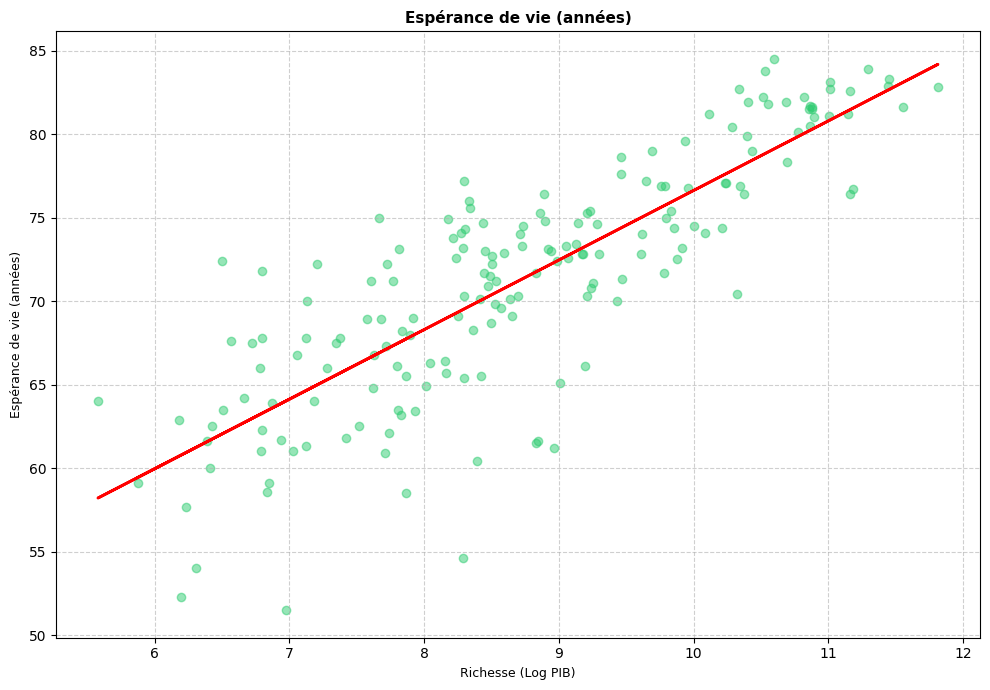


RESUME DES REGRESSIONS

Espérance de vie (années)
----------------------------------------------------------------------
                               OLS Regression Results                              
Dep. Variable:     Espérance de vie totale   R-squared:                       0.685
Model:                                 OLS   Adj. R-squared:                  0.683
Method:                      Least Squares   F-statistic:                     429.8
Date:                     Sun, 28 Dec 2025   Prob (F-statistic):           3.16e-49
Time:                             18:21:31   Log-Likelihood:                -502.35
No. Observations:                      179   AIC:                             1009.
Df Residuals:                          177   BIC:                             1015.
Df Model:                                1                                         
Covariance Type:                       HC1                                         
                 coef    std err      

In [125]:
importlib.reload(gp)
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Espérance de vie totale', 'Espérance de vie (années)', 'regression')
        ],
        disposition="1"
    )

L'analyse de la régression linéaire montre une corrélation positive entre la richesse d'un pays et l'espérance de vie de ses habitants. Une augmentation de 10% du PIB par habitant se traduit par une augmentation de l'espérance de vie d'environ 0,4 an (soit environ 5 mois). Ce résultat semble cohérent, plus un pays se développe économiquement, plus ses citoyens vivent longtemps, car la croissance permet un meilleur accès aux soins, à l'eau potable et à une meilleure alimentation.

Nous avons privilégié l'espérance de vie totale pour sa plus grande robustesse statistique, le PIB expliquant mieux sa variation avec un impact plus marqué (coefficient de 4,17). Contrairement à l'espérance de vie en bonne santé, cet indicateur constitue un standard international fiable reposant sur des données de mortalité précises et objectives. Ce choix permet ainsi une analyse plus rigoureuse et comparable du lien entre croissance économique et survie de la population.

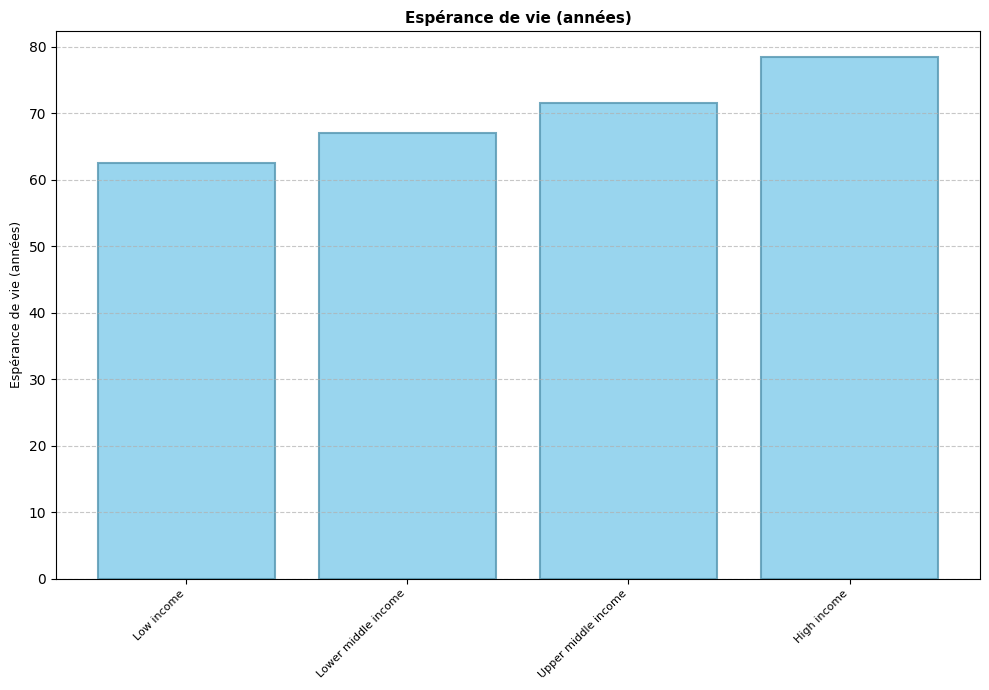


RESUME DES REGRESSIONS

Espérance de vie (années)
----------------------------------------------------------------------
                               OLS Regression Results                              
Dep. Variable:     Espérance de vie totale   R-squared:                       0.685
Model:                                 OLS   Adj. R-squared:                  0.683
Method:                      Least Squares   F-statistic:                     429.8
Date:                     Sun, 28 Dec 2025   Prob (F-statistic):           3.16e-49
Time:                             18:21:31   Log-Likelihood:                -502.35
No. Observations:                      179   AIC:                             1009.
Df Residuals:                          177   BIC:                             1015.
Df Model:                                1                                         
Covariance Type:                       HC1                                         
                 coef    std err      

In [126]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Espérance de vie totale', 'Espérance de vie (années)', 'barres')
        ],
        disposition="1"
    )

Le graphique confirme une corrélation directe entre le niveau de richesse et la longévité : on observe une progression constante de l'espérance de vie à chaque palier de revenu, passant de 62,5 ans pour les pays à faible revenu à plus de 78,4 ans pour les pays à haut revenu. Cet écart massif de près de 16 ans souligne que le développement économique reste un facteur déterminant pour l'amélioration des conditions de santé globales. 

#### Taux de mortalité néonatal et maternel
---

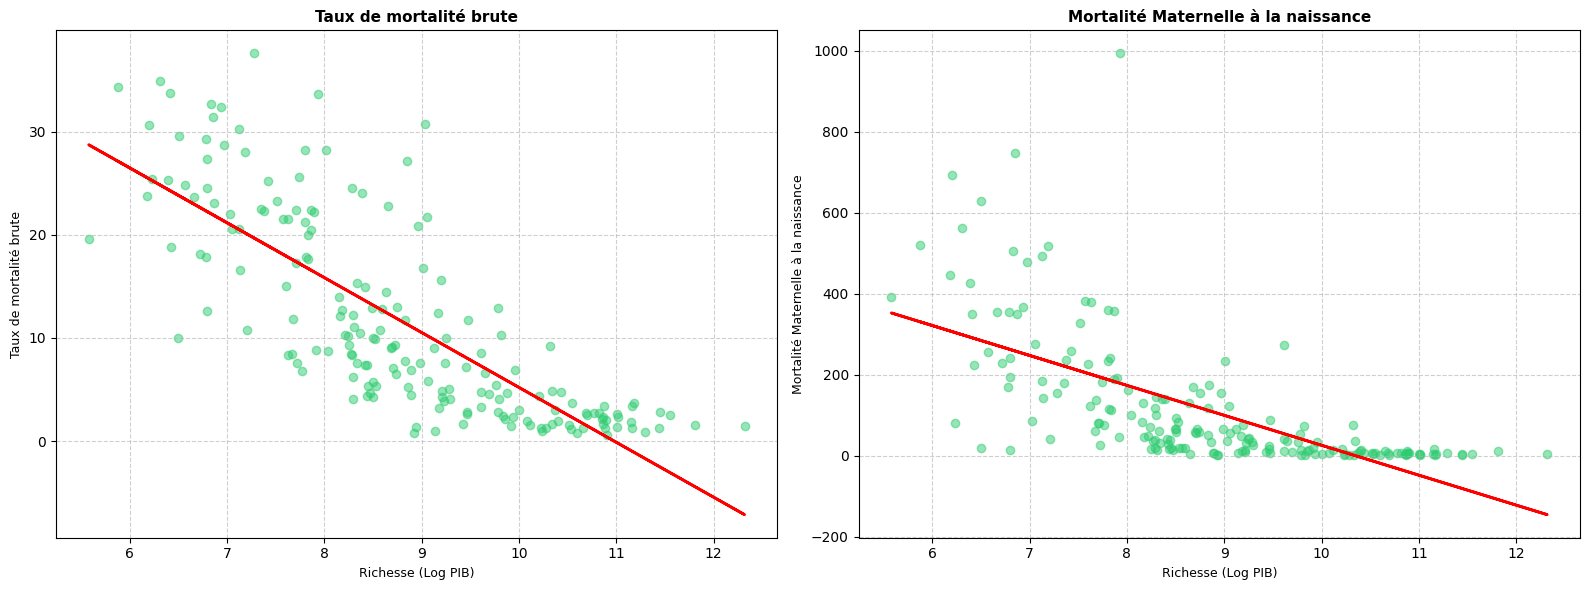


RESUME DES REGRESSIONS

Taux de mortalité brute
----------------------------------------------------------------------
                             OLS Regression Results                             
Dep. Variable:     Taux mortalité brute   R-squared:                       0.615
Model:                              OLS   Adj. R-squared:                  0.613
Method:                   Least Squares   F-statistic:                     335.4
Date:                  Sun, 28 Dec 2025   Prob (F-statistic):           2.06e-43
Time:                          18:21:31   Log-Likelihood:                -600.64
No. Observations:                   187   AIC:                             1205.
Df Residuals:                       185   BIC:                             1212.
Df Model:                             1                                         
Covariance Type:                    HC1                                         
                 coef    std err          z      P>|z|      [0.025    

In [127]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Taux mortalité brute', 'Taux de mortalité brute', 'regression'),
            ('Mortalité Maternelle à la naissance', 'Mortalité Maternelle à la naissance', 'regression')
        ],
        disposition="2"
    )

Ces deux graphiques nous montrent que le développement économique, mesuré par le log du PIB, agit comme un filet de sécurité vital. Cependant, son efficacité diffère : il est un prédicteur plus robuste pour la survie des nouveau-nés ($R^2$=0.63), que pour celle des mères ($R^2$=0.43).
Le coefficient négatif significatif dans les deux modèles confirme qu'une croissance économique soutenue est indispensable pour réduire le taux de mortalité néonatale. 

Mais la plus faible part de variance expliquée pour la mortalité maternelle souligne que la richesse du pays n'est pas le seul facteur, elle doit être accompagnée de politiques publiques ciblées sur l'accès aux soins d'urgence pour être pleinement efficace.
Ainsi, ces deux indicateurs sont complémentaires : la mortalité néonatale reflète le niveau d'équipement médical de base d'un pays, tandis que la mortalité maternelle révèle les limites de la croissance économique seule face aux enjeux d'organisation structurelle de la santé.

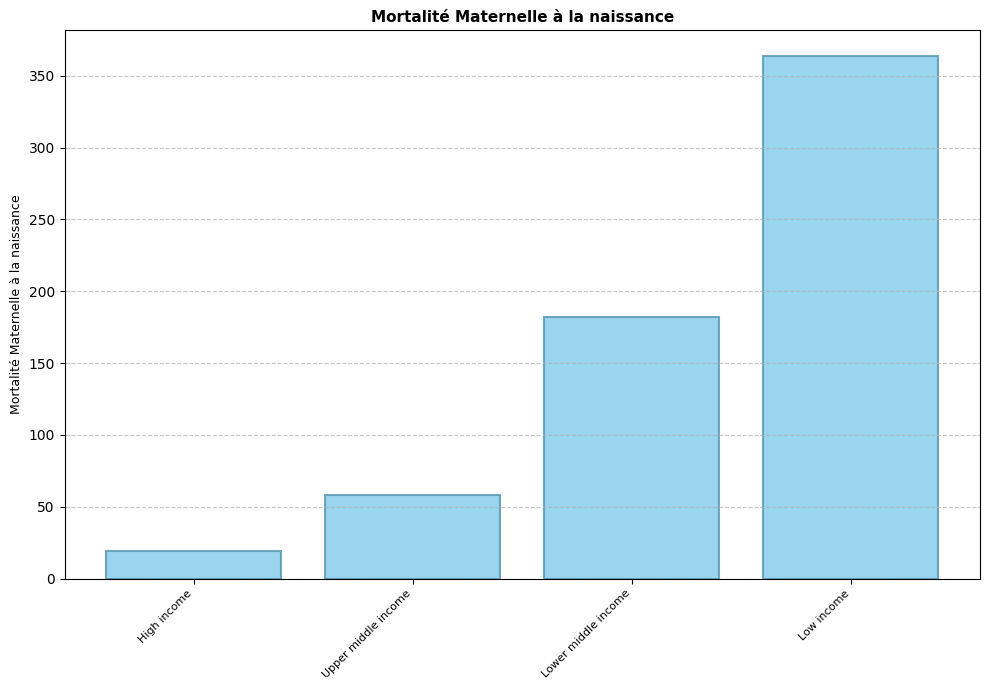


RESUME DES REGRESSIONS

Mortalité Maternelle à la naissance
----------------------------------------------------------------------
                                     OLS Regression Results                                    
Dep. Variable:     Mortalité Maternelle à la naissance   R-squared:                       0.428
Model:                                             OLS   Adj. R-squared:                  0.424
Method:                                  Least Squares   F-statistic:                     105.0
Date:                                 Sun, 28 Dec 2025   Prob (F-statistic):           8.13e-20
Time:                                         18:21:32   Log-Likelihood:                -1169.9
No. Observations:                                  188   AIC:                             2344.
Df Residuals:                                      186   BIC:                             2350.
Df Model:                                            1                                         
Cova

In [128]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Mortalité Maternelle à la naissance', 'Mortalité Maternelle à la naissance', 'barres')
        ],
        disposition="1"
    )

Ce graphique en barres révèle un "effet de seuil" notable : le simple passage du groupe à faible revenu (Low income) au groupe intermédiaire inférieur (Lower middle income) permet de diviser par deux le taux de mortalité maternelle. Cela suggère que les investissements de base dans les soins obstétricaux d'urgence, rendus possibles par les premiers paliers de croissance, sont les plus importants.
De plus, on observe une décroissance exponentielle de la mortalité : si la richesse réduit le nombre de décès à chaque palier, l'écart massif de plus de 300 points entre les extrêmes souligne que la survie des mères reste l'indicateur le plus durement marqué par l'inégalité économique mondiale.

#### Infrastructures de soin et état de santé des populations
---

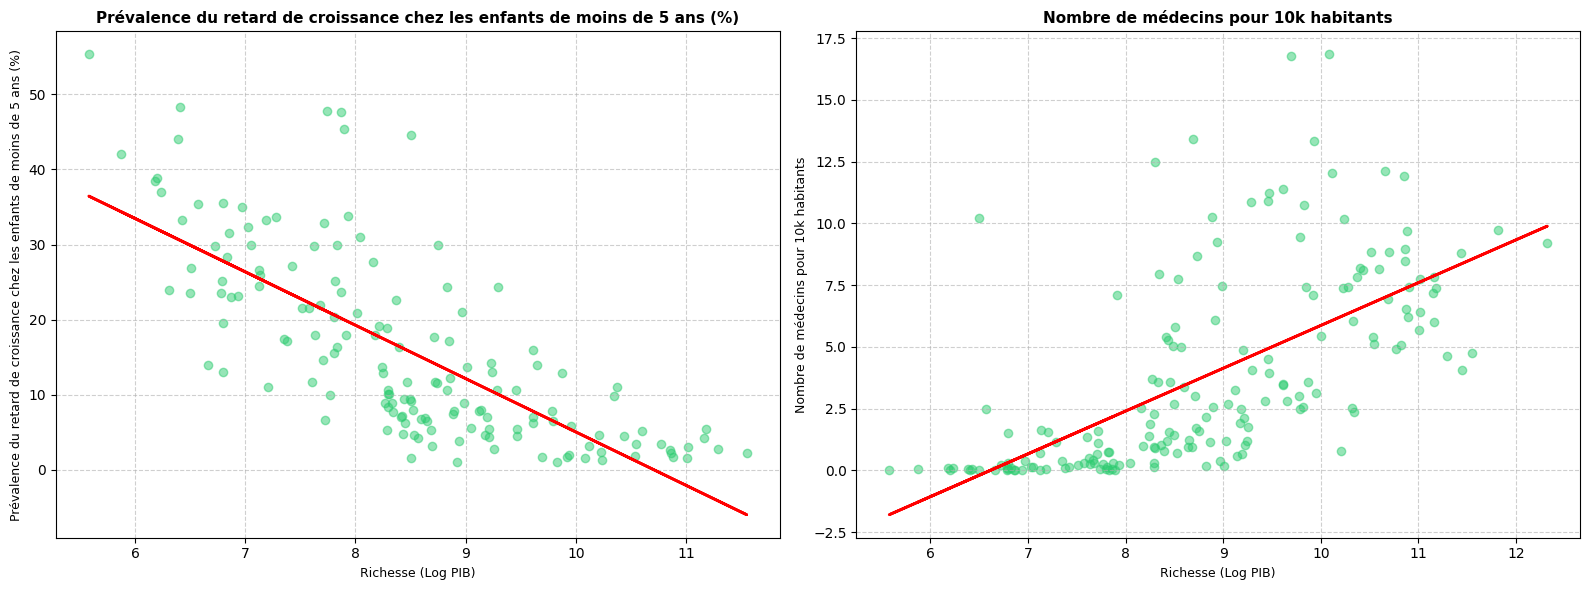


RESUME DES REGRESSIONS

Prévalence du retard de croissance chez les enfants de moins de 5 ans (%)
----------------------------------------------------------------------
                                OLS Regression Results                               
Dep. Variable:     Retard croissance enfants   R-squared:                       0.550
Model:                                   OLS   Adj. R-squared:                  0.547
Method:                        Least Squares   F-statistic:                     225.0
Date:                       Sun, 28 Dec 2025   Prob (F-statistic):           7.45e-32
Time:                               18:21:32   Log-Likelihood:                -548.41
No. Observations:                        155   AIC:                             1101.
Df Residuals:                            153   BIC:                             1107.
Df Model:                                  1                                         
Covariance Type:                         HC1            

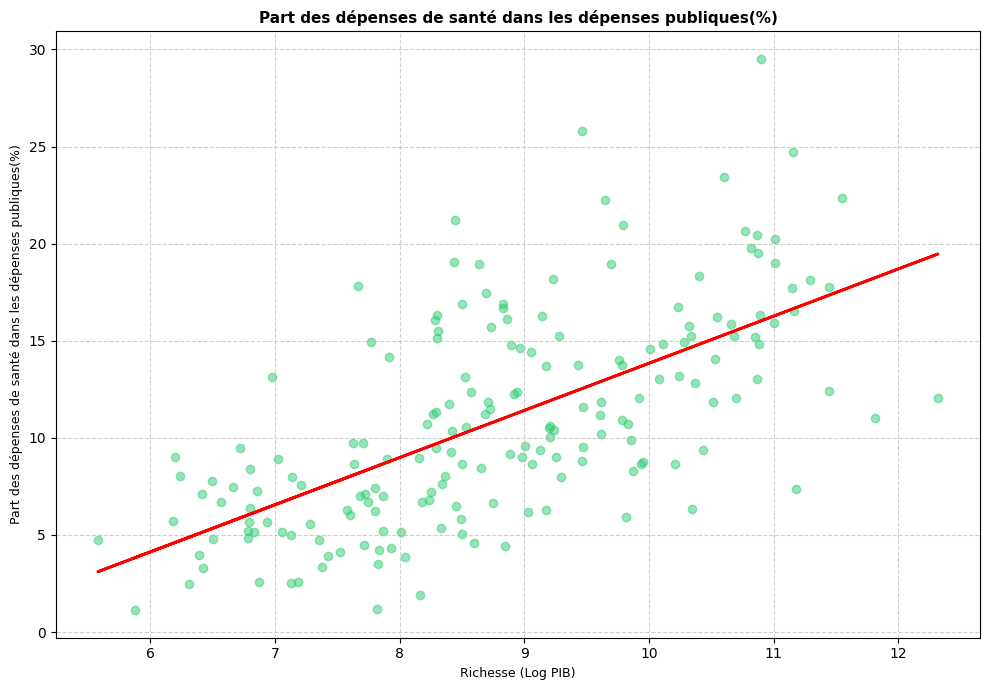


RESUME DES REGRESSIONS

Part des dépenses de santé dans les dépenses publiques(%)
----------------------------------------------------------------------
                               OLS Regression Results                               
Dep. Variable:     Dépenses publiques santé   R-squared:                       0.413
Model:                                  OLS   Adj. R-squared:                  0.410
Method:                       Least Squares   F-statistic:                     135.1
Date:                      Sun, 28 Dec 2025   Prob (F-statistic):           9.03e-24
Time:                              18:21:32   Log-Likelihood:                -527.97
No. Observations:                       186   AIC:                             1060.
Df Residuals:                           184   BIC:                             1066.
Df Model:                                 1                                         
Covariance Type:                        HC1                                      

In [129]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Retard croissance enfants', 'Prévalence du retard de croissance chez les enfants de moins de 5 ans (%)', 'regression'),
            ('Médecins pour 10k habitants', 'Nombre de médecins pour 10k habitants', 'regression')],
        disposition="2")

gp.afficher_graphiques(
        liste_indicateurs=[('Dépenses publiques santé', 'Part des dépenses de santé dans les dépenses publiques(%)', 'regression')],
        disposition="1")


        

L'analyse combinée de ces trois indicateurs de santé par rapport au niveau de richesse du pays montre une hiérarchie claire : le PIB est un moteur puissant pour les besoins vitaux primaires (diminution du retard de croissance), mais il devient un facteur secondaire lorsqu'il s'agit de structurer l'offre de soins (médecins, dépenses publiques).
Le faible $R^2$ des dépenses de santé (0.40) par rapport à celui du retard de croissance (0.61) prouve que si la richesse aide à nourrir une population, elle ne dicte pas automatiquement la qualité des politiques de santé publique.
Ainsi, le développement économique est une condition nécessaire pour sortir de l'urgence sanitaire, mais il est insuffisant pour bâtir un système de santé complet sans une volonté politique forte et durable.

Contrairement à d'autres indicateurs, le retard de croissance présente une progression en escalier quasi parfaite. Cette réduction systématique de la prévalence à chaque palier de revenu confirme que le développement économique agit comme un levier direct et constant sur la sécurité alimentaire et l'hygiène infantile.

### Impact du développement économique sur les indicateurs de santé mentale
---

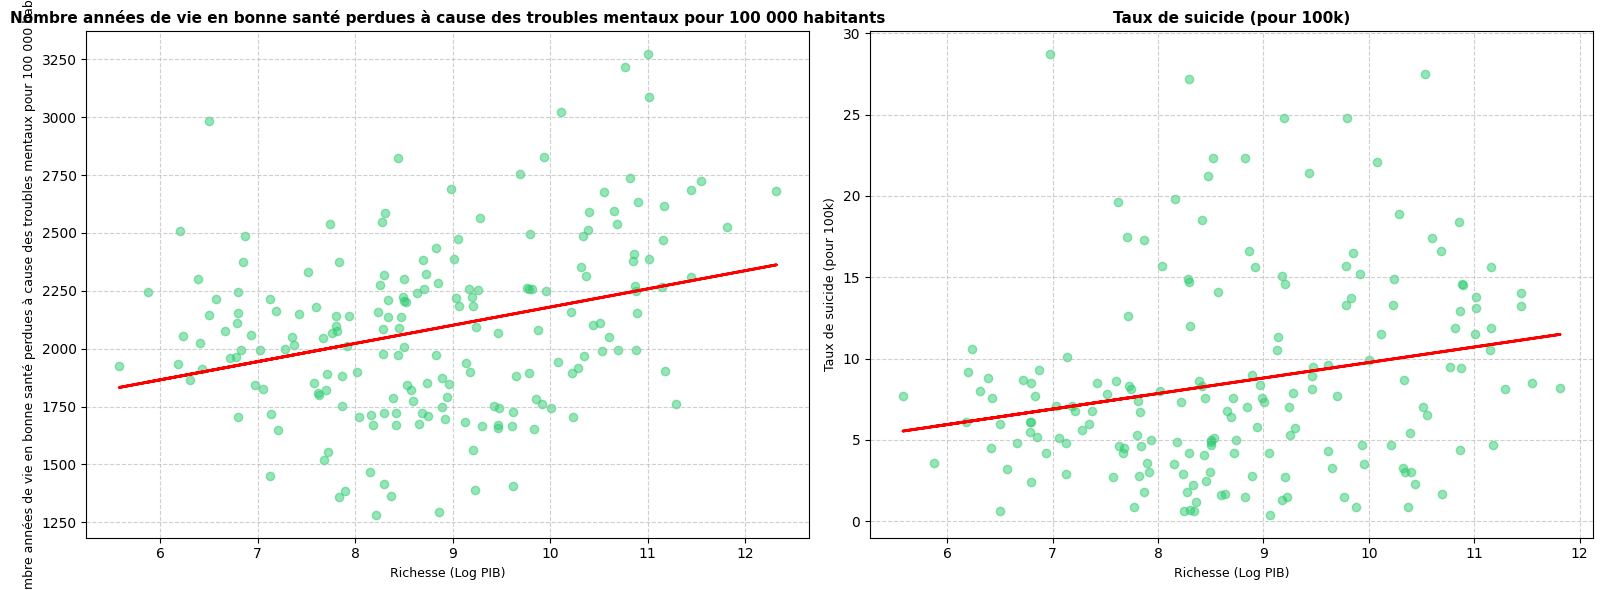


RESUME DES REGRESSIONS

Nombre années de vie en bonne santé perdues à cause des troubles mentaux pour 100 000 habitants
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:       Mental_disorders   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     17.83
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           3.77e-05
Time:                        18:21:33   Log-Likelihood:                -1371.4
No. Observations:                 188   AIC:                             2747.
Df Residuals:                     186   BIC:                             2753.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 c

In [130]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Mental_disorders', 'Nombre années de vie en bonne santé perdues à cause des troubles mentaux pour 100 000 habitants', 'regression'),
            ('Taux de suicides', 'Taux de suicide (pour 100k)', 'regression')
        ],
        disposition="2"
    )

L'analyse de la santé mentale marque une rupture nette avec nos observations précédentes. Pour la première fois, l'augmentation du PIB n'entraîne pas une amélioration des indicateurs : les troubles mentaux et le taux de suicide affichent des corrélations positives avec la richesse nationale.
Le très faible $R^2$ du taux de suicide (0.05) souligne que le développement économique n'agit pas comme un bouclier contre la détresse psychologique : ce phénomène échappe à la logique financière pour relever de facteurs culturels et sociaux profonds. Parallèlement, la corrélation positive observée pour les troubles mentaux ne traduit pas nécessairement une dégradation de la santé mentale dans les pays riches, mais plutôt une meilleure capacité de diagnostic. Là où un pays pauvre se concentre sur les urgences vitales, un pays développé dispose des infrastructures nécessaires pour identifier et comptabiliser l'anxiété ou la dépression. 

Ces résultats suggèrent donc que si le développement économique parvient à soigner les corps et à prolonger la vie, il ne répond pas automatiquement au bien-être de l'esprit. La santé mentale apparaît comme le "point mort" de la croissance économique, nécessitant des politiques sociales et humaines qui dépassent la simple accumulation de richesses.

### Impact du développement économique sur les indicateurs de santé alimentaire

---

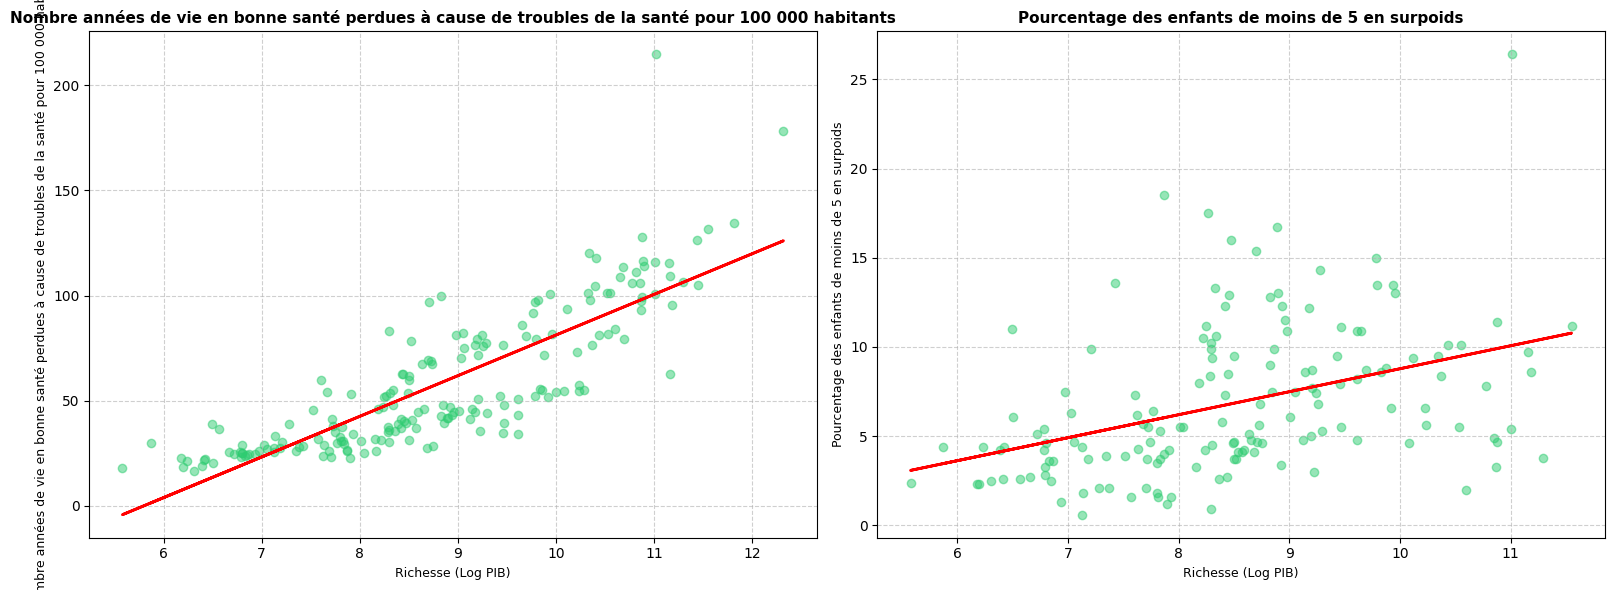


RESUME DES REGRESSIONS

Nombre années de vie en bonne santé perdues à cause de troubles de la santé pour 100 000 habitants
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:       Eating_disorders   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     296.2
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           2.50e-40
Time:                        18:21:33   Log-Likelihood:                -816.75
No. Observations:                 188   AIC:                             1637.
Df Residuals:                     186   BIC:                             1644.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
               

In [ ]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Eating_disorders', 'Nombre années de vie en bonne santé perdues à cause de troubles de la santé pour 100 000 habitants', 'regression'),
            ('Surpoids enfants <5 ans', 'Pourcentage des enfants de moins de 5 ans en surpoids', 'regression')
        ],
        disposition="2"
    )

On constate que l'augmentation du PIB par habitant agit comme un moteur de la transition nutritionnelle : si elle réduit la faim, elle déplace les enjeux sanitaires vers de nouvelles problématiques.
Sur le surpoids infantile : le développement économique favorise l'accès à une alimentation plus abondante mais souvent trop calorique (produits ultra-transformés), faisant du PIB un contributeur significatif, bien que partiel, de l'obésité précoce.
Sur les troubles alimentaires : Le lien est ici structurel et massif ($R^2$ de 69%). La richesse d'un pays s'accompagne d'une explosion de ces diagnostics, poussée par une pression sociale accrue et des systèmes de santé plus performants pour les identifier.
Ainsi, la croissance économique marque le passage de pathologies de "carence" à des pathologies de "surconsommation" et d'ordre psychologique, imposant des politiques publiques ciblées dès que le niveau de vie s'élève.

### Question de la réciprocité du lien économie-santé : les indicateurs sanitaires stimulent-ils la croissance économique ?
---
#### Modèle de régression linéaire multiple


--- REGRESSION MULTIPLE : SANTE -> PIB (2021) ---
Nombre de pays : 177

Modèle : Log(PIB) = β0 + β1×Espérance + β2×Mortalité + β3×Dépenses

                            OLS Regression Results                            
Dep. Variable:                   2021   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     189.3
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           2.09e-54
Time:                        18:21:33   Log-Likelihood:                -194.08
No. Observations:                 177   AIC:                             396.2
Df Residuals:                     173   BIC:                             408.9
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z| 

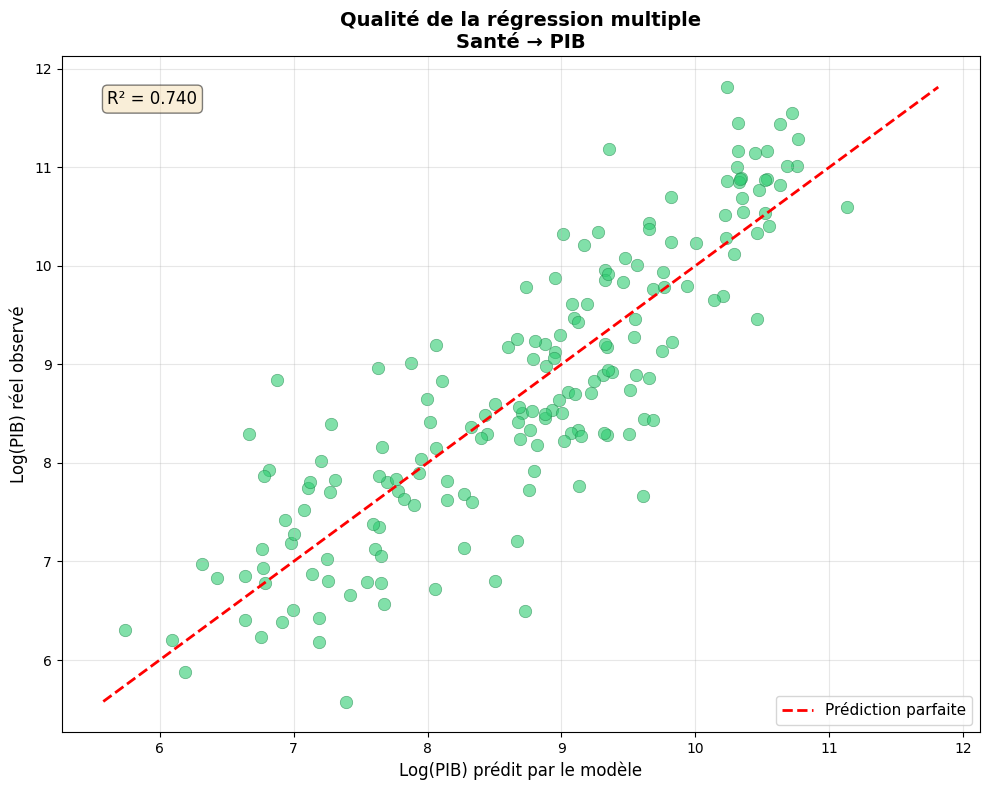

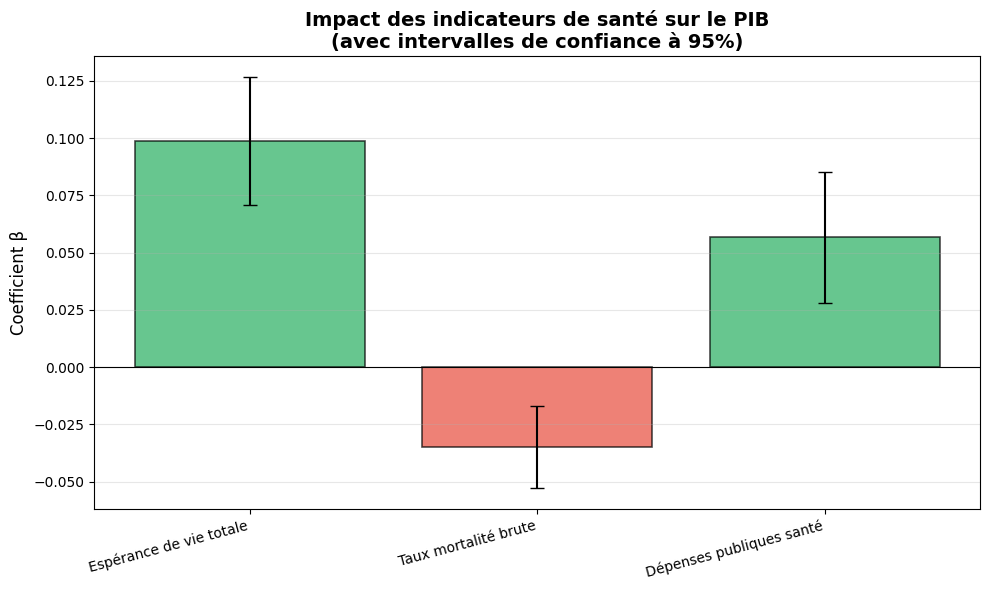

In [132]:
chemin = "Table_fusion.csv"
df = pd.read_csv(chemin)

model, df_clean = analyse_sante_vers_pib(df)
graphique_valeurs_predites_vs_reelles(model, df_clean)
graphique_coefficients(model)

L’analyse de notre modèle de régression multiple révèle une dépendance fondamentale entre la santé des populations et la performance économique nationale. Avec un coefficient de détermination $R^2$ de 0,740, notre modèle démontre que plus de 74 % de la variation du PIB mondial s'explique par seulement trois indicateurs sanitaires. La robustesse statistique globale (p-value quasi nulle) confirme que la santé n'est pas une simple conséquence de la richesse, mais un moteur déterminant de celle-ci.

Le choix des variables repose sur une vision complète du capital humain : l’espérance de vie mesure la viabilité à long terme de la force de travail, le taux de mortalité reflète la résilience face aux crises sanitaires, et les dépenses de santé traduisent l’engagement politique dans la protection des citoyens. Ces trois piliers forment un indicateur composite de la "santé économique" d'un pays, prouvant que le développement humain est indissociable du développement financier.

Les résultats soulignent l’influence prédominante de la longévité. Le modèle indique qu’une augmentation d’une seule année d'espérance de vie est associée à une hausse moyenne de 10 % du PIB. Ce gain massif s'explique par l'accumulation d'expérience, une productivité accrue et une meilleure stabilité sociale. À l'inverse, la mortalité agit comme un frein direct : chaque point supplémentaire de mortalité brute ampute le PIB d'environ 3,5 %, illustrant le coût économique des décès prématurés.

Enfin, l'étude valide la pertinence des politiques budgétaires de santé. Une hausse d'un point des dépenses publiques de santé dans le PIB génère mécaniquement une croissance de 5,6 % du PIB total. Ces données transforment la perception des budgets de santé : ils ne doivent plus être vus comme des coûts de fonctionnement, mais comme des investissements stratégiques à haut rendement. En somme, notre analyse prouve qu’investir dans le bien-être physique des citoyens est l’une des stratégies les plus efficaces pour garantir la prospérité économique d'un pays.

# Conclusion et perspectives

Ce projet permet de tirer des conclusions concrètes sur le lien entre développement économique et santé publique à partir des données internationales :

1) L'efficacité du PIB sur la survie physique : La croissance économique reste le levier le plus efficace pour répondre aux urgences vitales. Nos résultats montrent qu'une hausse du revenu par habitant réduit drastiquement la mortalité maternelle et le retard de croissance infantile. C'est dans les pays à faible revenu que l'impact de chaque point de croissance est le plus massif sur la survie.

2) La transition nutritionnelle : Nous observons un basculement des problématiques de santé avec la richesse. Alors que le retard de croissance recule quand le PIB augmente, le surpoids chez les enfants progresse. Le développement économique règle les problèmes de sous-nutrition mais expose les populations à de nouveaux risques liés à la surconsommation et à la qualité de l'alimentation.
Le point mort de la santé mentale : Contrairement aux indicateurs physiques, la santé mentale (suicides et troubles mentaux) ne s'améliore pas avec la croissance du PIB. Les enjeux psychologiques semblent davantage liés à des facteurs culturels et sociaux qu'au niveau de richesse. La croissance économique prolonge la vie, mais elle ne garantit pas mécaniquement un meilleur bien-être mental.

3) La santé comme moteur économique : Enfin, la relation est bidirectionnelle. Notre modèle montre que la santé n'est pas qu'une dépense : une population qui vit plus longtemps est plus productive. Avec un $R^2$ de 0,74, nous confirmons que le capital humain (santé et longévité) est l'un des principaux moteurs de la croissance du PIB.

En résumé, si la croissance économique est indispensable pour sortir les populations de l'insécurité sanitaire primaire, elle ne suffit pas à traiter les problématiques de santé complexes (mentales et nutritionnelles). Les politiques publiques doivent donc évoluer d'une logique de "quantité" (survie) vers une logique de "qualité" (bien-être global) à mesure qu'un pays s'enrichit.